# Tugas Mata Kuliah Deep Learning

- Model: Fully Connected Neural Network (FCNN)
- Oversampling: SMOTE
- Optimizer: Adam
- Validasi Silang: Holdout validation (train-test split)
- Metode Tambahan: EarlyStopping
- Fungsi Loss: Binary Crossentropy

Data Understanding dan Preliminary Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../dl-b-project/2/capture20110811.binetflow')

In [3]:
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                    StartTime       Dur Proto       SrcAddr  Sport    Dir  \
0  2011/08/11 09:53:40.240135  9.016532   tcp  31.96.153.11  60257     ->   
1  2011/08/11 09:55:01.054702  2.903761   tcp  83.228.37.92   2571     ->   
2  2011/08/11 09:55:02.677188  3.032142   tcp  83.228.37.92   2574     ->   
3  2011/08/11 09:55:04.307051  2.932428   tcp  83.228.37.92   2576     ->   
4  2011/08/11 09:55:03.958463  6.017523   tcp  83.228.37.92   2571     ->   

         DstAddr  Dport   State  sTos  dTos  TotPkts  TotBytes  SrcBytes  \
0  147.32.84.229    443  SRA_SA   0.0   0.0        7       508       208   
1  147.32.84.229  13363   SR_SA   0.0   0.0        3       184       122   
2  147.32.84.229    443   SR_SA   0.0   0.0        3       184       122   
3  147.32.84.229     80   SR_SA   0.0   0.0        3       184       122   
4  147.32.84.229  13363   SR_SA   0.0   0.0        3       184       122   

                             Label  
0  flow=Background-TCP-Es

In [15]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808122 entries, 0 to 1808121
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   StartTime  object 
 1   Dur        float64
 2   Proto      object 
 3   SrcAddr    object 
 4   Sport      object 
 5   Dir        object 
 6   DstAddr    object 
 7   Dport      object 
 8   State      object 
 9   sTos       float64
 10  dTos       float64
 11  TotPkts    int64  
 12  TotBytes   int64  
 13  SrcBytes   int64  
 14  Label      object 
dtypes: float64(3), int64(3), object(9)
memory usage: 206.9+ MB
None


In [16]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                Dur          sTos          dTos       TotPkts      TotBytes  \
count  1.808122e+06  1.803798e+06  1.538287e+06  1.808122e+06  1.808122e+06   
mean   4.006726e+02  2.970399e-02  3.510398e-04  3.973805e+01  3.503811e+04   
std    9.516550e+02  2.297207e+00  2.970989e-02  4.073724e+03  4.190502e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  6.000000e+01   
25%    3.140000e-04  0.000000e+00  0.000000e+00  2.000000e+00  2.140000e+02   
50%    2.147000e-03  0.000000e+00  0.000000e+00  2.000000e+00  2.610000e+02   
75%    8.996974e+00  0.000000e+00  0.000000e+00  5.000000e+00  5.870000e+02   
max    3.600034e+03  1.920000e+02  3.000000e+00  4.077379e+06  4.376239e+09   

           SrcBytes  
count  1.808122e+06  
mean   2.210684e+03  
std    3.034949e+05  
min    0.000000e+00  
25%    7.900000e+01  
50%    8.500000e+01  
75%    3.100000e+02  
max    2.485222e+08  


In [17]:
print("\nUnique Labels in 'Label':")
print(df['Label'].value_counts())


Unique Labels in 'Label':
Label
flow=To-Background-UDP-CVUT-DNS-Server                                     660177
flow=Background-UDP-Established                                            602264
flow=Background-UDP-Attempt                                                201380
flow=Background-TCP-Established                                            149962
flow=Background-Established-cmpgw-CVUT                                      78133
                                                                            ...  
flow=From-Botnet-V43-TCP-Established-HTTP-Ad-60                                 1
flow=From-Botnet-V43-TCP-HTTP-Not-Encrypted-Down-2                              1
flow=From-Botnet-V43-TCP-Established-HTTP-Binary-Download-Custom-Port-5         1
flow=From-Botnet-V43-TCP-Established-HTTP-Binary-Download-Custom-Port-7         1
flow=From-Botnet-V43-TCP-Established-HTTP-Ad-23                                 1
Name: count, Length: 132, dtype: int64


In [7]:
df.isnull().sum()

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Data Cleaning

In [8]:
def clean_data(df):
    # Handle missing values
    df['Sport'] = df['Sport'].fillna('unknown')
    df['Dport'] = df['Dport'].fillna('unknown')
    df['sTos'] = df['sTos'].fillna(0)
    df['dTos'] = df['dTos'].fillna(0)
    
    # Convert timestamp to features
    df['StartTime'] = pd.to_datetime(df['StartTime'])
    df['Hour'] = df['StartTime'].dt.hour
    df['Day'] = df['StartTime'].dt.day
    df['Month'] = df['StartTime'].dt.month
    
    # Binary label (1 for Botnet, 0 for Normal)
    df['Label'] = df['Label'].apply(lambda x: 1 if 'Botnet' in x else 0)
    
    return df

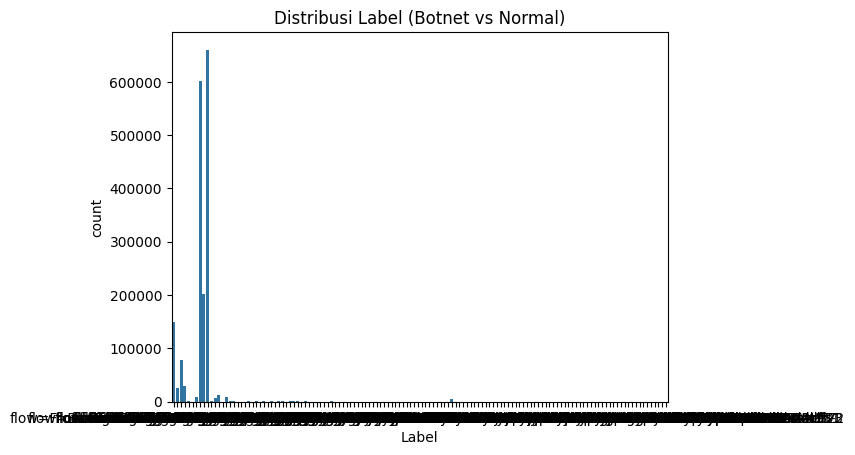

In [9]:
# Distribusi kelas
sns.countplot(data=df, x='Label')
plt.title('Distribusi Label (Botnet vs Normal)')
plt.show()

Feature Engineering

In [11]:
def engineer_features(df):
    # Create new features
    df['BytesPerPacket'] = df['TotBytes'] / df['TotPkts']
    df['BytesPerSecond'] = df['TotBytes'] / df['Dur'].replace(0, 1)
    df['PacketsPerSecond'] = df['TotPkts'] / df['Dur'].replace(0, 1)
    df['SrcBytesRatio'] = df['SrcBytes'] / df['TotBytes'].replace(0, 1)
    
    # Encode categorical variables
    categorical_features = ['Proto', 'State', 'Dir']
    label_encoders = {}
    
    for feature in categorical_features:
        label_encoders[feature] = LabelEncoder()
        df[feature] = label_encoders[feature].fit_transform(df[feature])
    
    # Select final features
    features = ['Dur', 'Proto', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes',
                'SrcBytes', 'Hour', 'BytesPerPacket', 'BytesPerSecond',
                'PacketsPerSecond', 'SrcBytesRatio']
    
    return df[features], df['Label'], label_encoders

Create Deep Learning Model

In [13]:
def create_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), 
                         tf.keras.metrics.Recall()])
    
    return model

Main Pipeline

c:\Users\AHMAD ZAKI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8936/8936 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9100 - loss: 0.2133 - precision: 0.8684 - recall: 0.9051 - val_accuracy: 0.7641 - val_loss: 0.4751 - val_precision: 1.0000 - val_recall: 0.7641
Epoch 2/20
8936/8936 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9453 - loss: 0.1390 - precision: 0.9329 - recall: 0.9208 - val_accuracy: 0.9079 - val_loss: 0.3009 - val_precision: 1.0000 - val_recall: 0.9079
Epoch 3/20
8936/8936 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9476 - loss: 0.1333 - precision: 0.9371 - recall: 0.9223 - val_accuracy: 0.8818 - val_loss: 0.5174 - val_precision: 1.0000 - val_recall: 0.8818
Epoch 4/20
8936/8936 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9497 - loss: 0.1300 - precision: 0.9409 - recall: 0.9241 - val_accuracy: 0.7248 - val_loss: 0.4170 - val_precision: 1.0000 - val_recall: 0.7248
Epoch 5/20
8936/8936 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9514 - loss: 0.1262 - precision: 0.9432 - recall: 0.9261 - val_accuracy: 0.0473

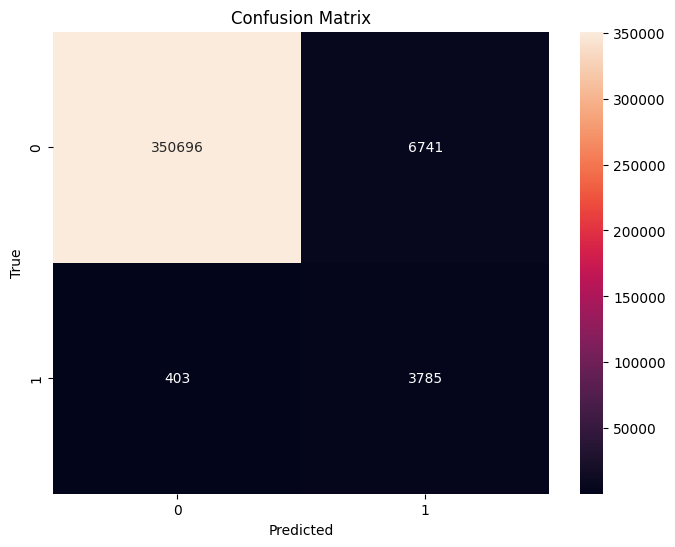

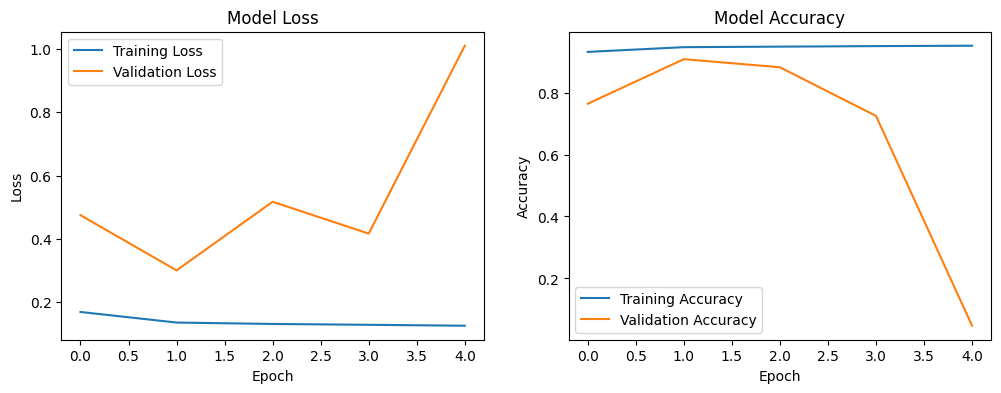

In [ ]:
def main():
    # Load data
    df = pd.read_csv('../dl-b-project/2/capture20110811.binetflow')
        
    # Clean data
    df = clean_data(df)
    
    # Engineer features
    X, y, label_encoders = engineer_features(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE for balanced training
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    # Create and train model
    model = create_model(X_train.shape[1])
    
    history = model.fit(
        X_train_balanced, y_train_balanced,
        epochs=20,
        batch_size=256,
        validation_split=0.2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate model
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    
    # Print evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Save model and preprocessing objects
    model.save('fcnn_smote_adam_binary_crossentropy_earlystopping.h5')
    np.save('scaler.npy', scaler.get_params())
    
    return model, scaler, label_encoders

if __name__ == "__main__":
    model, scaler, label_encoders = main()